<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.1-MNIST" data-toc-modified-id="3.1-MNIST-1">3.1 MNIST</a></span></li><li><span><a href="#3.2-이진-분류기-훈련" data-toc-modified-id="3.2-이진-분류기-훈련-2">3.2 이진 분류기 훈련</a></span></li><li><span><a href="#3.3-성능-측정" data-toc-modified-id="3.3-성능-측정-3">3.3 성능 측정</a></span><ul class="toc-item"><li><span><a href="#교차-검증을-사용한-정확도-측정" data-toc-modified-id="교차-검증을-사용한-정확도-측정-3.1">교차 검증을 사용한 정확도 측정</a></span></li><li><span><a href="#교차-검증-기능-직접-구현하기" data-toc-modified-id="교차-검증-기능-직접-구현하기-3.2"><code>교차 검증 기능 직접 구현하기</code></a></span></li><li><span><a href="#오차-행렬" data-toc-modified-id="오차-행렬-3.3">오차 행렬</a></span></li><li><span><a href="#정밀도와-재현율" data-toc-modified-id="정밀도와-재현율-3.4">정밀도와 재현율</a></span></li><li><span><a href="#정밀도/재현율-트레이드오프" data-toc-modified-id="정밀도/재현율-트레이드오프-3.5">정밀도/재현율 트레이드오프</a></span></li><li><span><a href="#ROC-곡선" data-toc-modified-id="ROC-곡선-3.6">ROC 곡선</a></span></li></ul></li><li><span><a href="#3.4-다중-분류" data-toc-modified-id="3.4-다중-분류-4">3.4 다중 분류</a></span></li><li><span><a href="#3.5-에러-분석" data-toc-modified-id="3.5-에러-분석-5">3.5 에러 분석</a></span></li></ul></div>

## 3.1 MNIST

MNIST 데이터셋은 학습용으로 아주 많이 사용되기 때문에 러신러닝의 "Hello World" 라고 합니다.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',
  'pixel51',
  '

사이킷런에서 읽어들인 데이터셋들은 일반적으로 비숫한 딕셔너리 구조를 가지고 있습니다.

- 데이터셋을 설명하는 **`DESCR`** 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 **`data`** 키
- 레이블 배열을 담고 있는 **`target`** 키

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

`데이터를 더 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야합니다.`<br>
MNIST 데이터셋은 이미 훈련 세트(앞쪽 60,000개)와 테스트 세트(뒤쪽 10,000개)로 나누어 놓았습니다.

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

`훈련 세트를 섞어서 모든 교차 검증 폴드가 비슷해지도록 만들겠습니다.` <br>
시계열 데이터의 경우 데이터를 섞는 것이 좋지 않습니다.

In [5]:
import numpy as np

shuffle_index = np.random.permutation(60000)    # 6만개의 무작위 인덱스 값을 생성 (실행할 때 마다 변경됨)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [6]:
np.where(y_train == '5')[0][:10]    # "5"가 있는 인덱스 찾기

array([  8,  11,  25,  34,  45,  46,  51,  91, 102, 110])

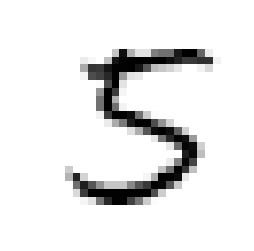

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X_train[8]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

In [8]:
# 실제 레이블 확인
y_train[8]

'5'

## 3.2 이진 분류기 훈련

"5"와 "5 아님" 두 개의 클래스를 구분하는 이진 분류기(binary classifier)를 만들어 보겠습니다.

In [9]:
y_train_5 = (y_train == '5')    # '5'는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == '5')

In [10]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

- 확률적 경사 하강법(Stochastic Gradient Descent) 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점이 있습니다.<br>
   SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문입니다. (그래서 SGD가 온라인 학습에 잘 들어맞습니다.)

In [11]:
sgd_clf.predict([some_digit])    # 위에서 확인한 "5"를 정확인 예측하면 True

array([ True])

## 3.3 성능 측정

### 교차 검증을 사용한 정확도 측정

사이킷런의 `cross_val_score()`함수로 폴드가 3개인 K-겹 교차 검증을 사용해 SGD 모델을 평가해보겠습니다.<br>
K-겹 교차 검증은 훈련 세트를 K개(여기서는 3개)의 폴드로 나누고, <br>
각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용합니다.

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9605 , 0.95595, 0.95375])

- 95% 수준의 정확도는 매우 높은 것으로 보입니다.
- 모든 이미지를 "5 아님" 클래스로 분류하는('5'를 하나도 맞추지 못하는) 더미 분류기를 만들어서 정확도를 비교해보겠습니다.

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)    # 모든 값이 False(즉, "5 아님")인 배열

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90745, 0.9125 ])

- '5'를 하나도 맞추지 못해도 정확도가 90% 입니다. 이미지의 10% 정도만 '5' 이기 때문입니다.<br>
   `이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여 줍니다.`<br>
   특히, 불균형 한 데이터셋(즉, 어떤 클래스가 다른 것보다 월등히 많은 경우)을 다룰 때 더욱 그렇습니다.

### `교차 검증 기능 직접 구현하기`

사이킷런에서 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있는 경우 아래와 같이 직접 구현하면 됩니다.

StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행 합니다.<br>
매 반복마다 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듭니다.<br>
그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력합니다.

다음 코드는 **`cross_val_score()`** 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력 합니다.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9605
0.95595
0.95375


### 오차 행렬

**`분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬(confusion matrix)를 조사하는 것입니다.`**<br>
기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 회수를 세는 것입니다.

오차 행렬을 만들려면 실제 타깃 값과 비교할 수 있도록 먼저 예측값을 만들어야 합니다.<br>
**`cross_val_predict()`** 함수는 K-겹 교차 검증을 수행하여, 각 테스트 폴드에서 얻은 예측을 반환 합니다.<br>
즉, 훈련 세트의 모든 샘플에 대해 깨끗한(훈련하는 동안 보지 못했던 데이터에 대한) 예측을 얻게 됩니다.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

**`confusion_matrix()`** 함수를 사용해 오차 행렬을 만듭니다.

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52972,  1607],
       [  989,  4432]])

- 오차 행렬의 **행은 실제 클래스**를 나타내고, **열은 예측한 클래스**를 나타냅니다.
- 위 행렬의 첫번째 행은 "5 아님" 이미지(**음성 클래스, Negative Class**)에 대한 것으로,<br>
   52,972개를 "5 아님"으로 정확히 분류했고(**진짜 음성, True Negative**), <br>
   나머지 1,607개는 "5"라고 잘못 분류했습니다.(**거짓 양성, False Positive**)
- 두번째 행은 "5" 이미지(**양성 클래스, Positive Class**)에 대한 것으로, <br>
   989개를 "5 아님"으로 잘못 분류했고(**거짓 음성, False Negative**), <br>
   나머지 4,432개를 정확히 "5"라고 분류했습니다.(**진짜 양성, True Positive**)

![오차 행렬](./images/fig3-2.png)

In [20]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)    # 완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있음(주대각선만 0이 아닌 값이 됨)

array([[54579,     0],
       [    0,  5421]])

---
조금 더 요약된 지표가 필요할 때 살펴볼만한 것은 양성 예측의 정확도 입니다.<br>
이를 분류기의 **정밀도(Precision)** 라고 합니다.

$\text{정밀도} = \large \frac{TP}{TP + FP}$

- TP는 진짜 양성의 수, FP는 거짓 양성의 수
- 확실한 진짜 양성 하나만 True로 예측하고 나머지를 모두 False로 예측해도(즉, 다른 양성 샘플을 무시해도) 정밀도가 100%가 되는 문제가 있음

정밀도는 **재현율(Recall)** 이라는 또 다른 지표와 같이 사용하는 것이 일반적입니다.<br>
재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로, **민감도(Sensitivity)** 또는 <br>
**진짜 양성 비율(True Positive Rate, TPR)** 이라고도 합니다.

$\text{재현율} = \large \frac{TP}{TP+FN}$

- FN은 거짓 음성의 수

### 정밀도와 재현율

사이킷런은 정밀도(**`precision_score()`**)와 재현율(**`recall_score()`**)을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공합니다.

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7338963404537175

In [22]:
recall_score(y_train_5, y_train_pred)

0.8175613355469471

- 정밀도와 재현율을 보니, 정확도만 봤을 때에 비해 훌륭한 결과는 아닙니다.

정밀도와 재현율을 $F_1$ **점수(F1 Score)** 라고 하는 하나의 숫자로 만들어 관리할 때가 많습니다.<br>
$F_1$ 점수는 정밀도와 재현율의 **조화 평균(Harmonic Mean)** 입니다.

$$
   F_1 = \frac{2}{\frac{1}{\text{정밀도}} + \frac{1}{\text{재현율}}} = 
   2 \times \frac{\text{정밀도} \times \text{재현율}}{\text{정밀도} + \text{재현율}} = 
   \frac{TP}{TP + {\frac{FN + FP}{2}}}
$$

$F_1$ 점수의 일반화된 조화 평균 식은 다음과 같습니다.

$$
   F = \frac{1}{\frac{\alpha}{\text{정밀도}} + \frac{1 - \alpha}{\text{재현율}}} = 
   (\beta^2 + 1) \times \frac{\text{정밀도} \times \text{재현율}}{\beta^2 \times \text{정밀도} + \text{재현율}}
$$

$$
   \beta^2 = \frac{1 - \alpha}{\alpha}
$$

- $\beta$가 1보다 크면 재현율이 강조되고, 1보다 작으면 정밀도가 강조됩니다.
- $\beta$가 1일 때(즉, $\alpha$가 $\frac{1}{2}$ 일때)의 $F$ 점수를 $F_1$ 점수라고 합니다.

$F_1$ 점수를 계산하려면 **`f1_score()`** 함수를 호출하면 됩니다.

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7734729493891798

- 정밀도와 재현율이 비슷한 분류기에서는 $F_1$ 점수가 높습니다.<br>
하지만 상황에 따라 정밀도가 중요할 수도 있고, 재현율이 중요할 수도 있습니다.

### 정밀도/재현율 트레이드오프

SGDClassifier 분류기는 **결정 함수(decision function)** 을 사용하여 각 샘플의 점수를 계산합니다.<br>
이 점수가 임계값 보다 크면 양성 클래스에 할당하고, 그렇지 않으면 음성 클래스에 할당합니다.<br>
임계값을 내리면 재현율이 높아지고, 정밀도는 줄어듭니다.

사이킷런에서 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수를 확인할 수 있습니다.<br>
**`decision_function()`** 메서드를 호출하면 각 샘플의 점수를 얻을 수 있습니다.<br>
이 점수를 기반으로 원하는 임계값을 정해 예측을 만들 수 있습니다.

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([218680.10512237])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- SGDClassifier의 임계값이 0이므로 위 코드는 predict() 메서드와 동일한 결과를 반환합니다.

In [28]:
threshold = 220000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 이 결과는 임계값을 높이면 재현율이 줄어든다는 것을 보여줍니다.

그렇다면, 적절한 임계값을 어떻게 정할 수 있을까요?<br>

먼저 **`cross_val_predict()`** 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 합니다.<br>
예측 결과가 아닌 결정 점수를 반환하도록 method='decision_function'을 지정합니다.

**`precision_recall_curve()`** 함수를 사용하여 가능한 모든 임계값에 대해 정밀도와 재현율을 계산할 수 있습니다.

In [54]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

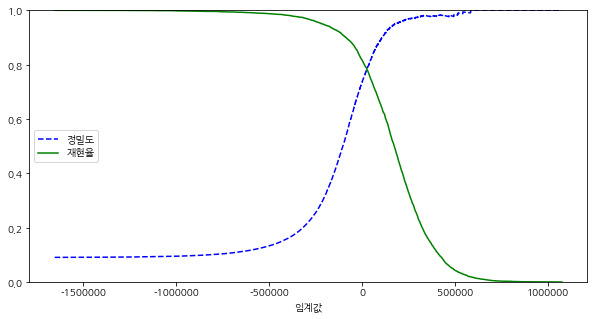

In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    plt.xlabel("임계값")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plt.figure(figsize=(10, 5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 정밀도 곡선이 재현율 곡선 보다 더 울퉁불퉁 합니다. 이는 임계값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문입니다.
- `작업에 맞는 정밀도/재현율 트레이드오프를 만드는 임계값을 선택하면 됩니다.`
- `재현율에 대한 정밀도 곡선`을 그리면 좋은 정밀도/재현율 트레이트오프를 선택하는 데 도움이 됩니다.

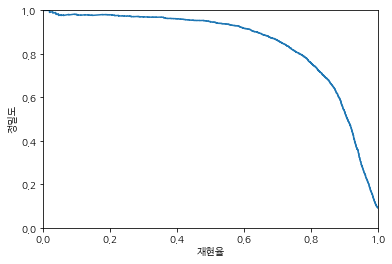

In [56]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("재현율")
    plt.ylabel("정밀도")
    plt.ylim([0, 1])
    plt.xlim([0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

정밀도 90%를 달성하는 것이 목표라고 자정하면, 아래 코드를 통해 임계값이 108,211 정도라는 것을 알 수 있습니다.

In [57]:
thresholds_90 = thresholds[np.argmin(np.array(abs(precisions - 0.9)))]
thresholds_90

108211.16683102472

훈련 세트에 대한 정밀도 90%인 예측값을 만들려면 분류기의 predict() 메서드 대신 다음 코드를 실행하면 됩니다.

In [58]:
y_train_pred_90 = (y_scores > thresholds_90)
precision_score(y_train_5, y_train_pred_90)

0.899948024948025

In [59]:
recall_score(y_train_5, y_train_pred_90)

0.638812027301236

- 재현율이 너무 낮다면 높은 정밀도의 분류기는 전현 유용하지 않습니다.<br>
   `누군가 "99% 정밀도를 달성하자"라고 말하면 반드시 "재현율 얼마에서?"라고 물어봐야 합니다.`

### ROC 곡선

**`수신기 조작 특성(Receiver Operating Characteristic, ROC)`** 곡선도 이진 분류에서 널리 사용되는 도구 입니다.

정밀도/재현율 곡선과 매우 비슷하지만, ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고,<br>
**`거짓 양성 비율(False Positive Rate, FPR)`** 에 대한 **`진짜 양성 비율(True Positive Rate, TPR, 재현율의 다른 이름)`** 의 곡선 입니다.

양성으로 잘못 분류된 음성 샘플의 비율이 FPR 입니다. <br>
이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 **`진짜 음성 비율(True Negative Rate, TNR)`** 을 뺀 값입니다.<br>
TNR을 **`특이도(Specificity)`** 라고도 합니다. 
그러므로, ROC 곡선은 **`민감도(재현율)에 대한 "1 - 특이도"`** 그래프 입니다.

**`roc_curve()`** 함수를 사용해 여러 임계값에서 TPR과 FPR을 계산해야 합니다.

In [60]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

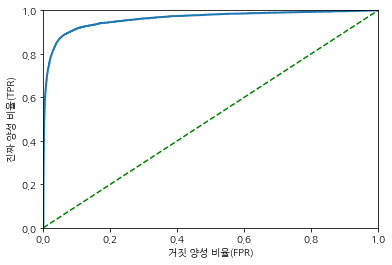

In [61]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)      # threshold = 0 인 분류기의 ROC 곡선(threshold = 0 인 y_scores에 대한 ROC 곡선)
    plt.plot([0, 1], [0, 1], 'g--')       # 완전한 랜덤 분류기의 ROC 곡선
    plt.axis([0, 1, 0, 1])
    plt.xlabel("거짓 양성 비율(FPR)")
    plt.ylabel("진짜 양성 비율(TPR)")
    
plot_roc_curve(fpr, tpr)
plt.show()

- 좋은 분류기는 완전한 랜덤 분류기의 ROC 곡선으로부터 최대한 멀리 떨어져 있어야 합니다.(왼쪽 위 모서리)

**`곡선 아래의 면적(Area Under the Curve, AUC)`** 을 측정하면 분류기들을 비교할 수 있습니다.<br>
완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5 입니다.<br>
사이킷런은 ROC의 AUC를 계산하는 **`roc_auc_score()`** 함수를 제공합니다.

In [62]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9614189997126434

`양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 정밀도/재현율(PR) 곡선을 사용하고,
그렇지 않으면 ROC 곡선을 사용합니다.`

위의 예에서 ROC 곡선을 보면 매우 좋은 분류기라고 생각할 수 있지만 이는 음성(5 아님)이 크게 적기 때문에 그렇게 보일 뿐입니다.<br>
이와는 다르게 PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지(오른쪽 위 모서리에 가까워질 수 있는지) 잘 보여 줍니다.

**`RandomForestClassifier`** 를 훈련시켜 SGDClassifier의 ROC AUC 점수를 비교해보겠습니다.

작동방식의 차이 때문에 RandomForestClassifier에는 decision_function() 메서드가 없습니다.<br>
대신 **`predict_proba()`** 메서드가 있습니다.<br>
사이킷런 분류기는 일반적으로 decision_function()와 predict_proba() 메서드 중 하나 또는 둘 모두를 가지고 있습니다.<br>
`predict_proba() 메서드는 샘플이 행, 클래스가 열이고, 샘플이 주어진 클래스에 속할 확율을 담은 배열을 반환합니다.`

In [64]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

ROC 곡선을 그리려면 확률이 아니라 점수가 필요합니다. 간단한 해결 방법은 양성 클래스의 확률을 점수로 사용하는 것입니다.

In [66]:
y_scores_forest = y_probas_forest[:, 1]       # 양성 클래스에 대한 확율을 점수로 사용 (0 컬럼은 음성 클래스의 확률, 1 컬럼은 양성 클래스의 확률)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

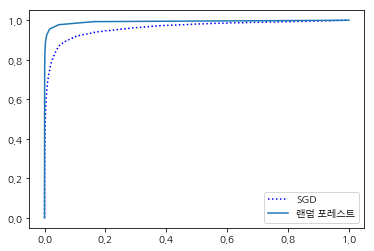

In [69]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

- RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier 보다 훨씬 더 좋아보입니다.<br>
   ROC AUC 점수도 훨씬 높습니다.

In [70]:
roc_auc_score(y_train_5, y_scores_forest)

0.9928250745111685

## 3.4 다중 분류

**`다중 분류기(Multiclass Classifier)`** 또는 **`다항 분류기(Multinomial Classifier)`** 는 둘 이상의 클래스를 구별할 수 있습니다.

랜덤 포레스트 분류기나 나이브 베이즈 분류기 같은 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면,<br>
서프트 벡터 머신이나 선형 분류기 같은 다른 알고리즘은 이진 분류만 가능합니다.<br>
하지만 **`이진 분류기를 여러 개 사용해 다중 클래스를 분류할 수 있습니다.`**

특정 숫자 하나 만 분류하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있습니다.<br>
이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 됩니다.<br>
이를 **`일대다(One-versus-All, One-versus-the-Rest, OvA)`** 전략이라고 합니다.

또 다른 전략은 1과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것입니다.<br>
이를 **`일대일(One-versus-One, OvO)`** 전략이라고 합니다.<br>
클래스가 N개라면 분류기는 N * (N-1) / 2 개가 필요합니다. MNIST 문제에서는 45개의 분류기를 훈련 시켜야 합니다.

`OvO 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것입니다.`<br>
서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다<br>
작은 훈련 세트에서 많은 분류기를 훈련시키는 것이 빠르므로 OvO 전략을 선호 합니다.<br>
하지만 `대부분의 분류 알고리즘은 OvA를 선호 합니다.`

**`다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 자동으로 감지해 OvA(SVM 일때는 OVO)를 적용합니다.`**<br>
SGDClassifier에 적용해보겠습니다.

In [75]:
sgd_clf.fit(X_train, y_train)     # y_train_5가 아니고, 10개의 클래스가 모두 구분되어 있는 y_train을 사용 합니다.
some_digit_pred = sgd_clf.predict([some_digit])
some_digit_pred

array(['5'], dtype='<U1')

- 내부에서는 사이킷런이 실제로 10개의 이진 분류기를 훈련시키고 각각의 결정 함수를 얻어 점수가 가장 높은 클래스를 선택합니다.
- **`decision_function()`** 메서드를 호출하면 확인할 수 있습니다.<br>
   이 메서드는 샘플 당 하나의 점수가 아니라, 클래스마다 하나씩 총 10개의 점수를 반환합니다.

In [76]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-386555.56853437, -570480.76347967, -339007.82252559,
        -169261.36303313, -312274.16410599,  218680.10512237,
        -711229.62659956, -643400.79491084,  -96547.61490441,
        -589608.04725533]])

- 분류기가 훈련될 때 **`classes_`** 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장합니다.<br>
   여기서는 클래스의 인덱스와 클래스 값 자체가 같지만 일반적으로 이런 경우는 드뭅니다.

In [77]:
np.argmax(some_digit_scores)

5

In [78]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

OvO나 OvA를 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용합니다.<br>
이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 됩니다.<br>
다음 코드는 SGDClassifier 기반으로 OvO 전략을 사용하는 다중 분류기를 만듭니다.

In [79]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array(['5'], dtype=object)

In [80]:
len(ovo_clf.estimators_)

45

랜덤 포레스트 분류기는 직접 샘플을 다중 분류할 수 있기 때문에 별도로 사이킷런의 OvO나 OvA를 적용할 필요가 없습니다.<br>
**`predict_proba()`** 메서드를 호출하면 분류기가 각 샘플에 부여한 클래스별 확률을 얻을 수 있습니다.

In [81]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['5'], dtype=object)

In [82]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

분류기의 평가에는 일반적으로 교차 검증을 사용합니다.<br>
**`cross_val_score()`** 함수를 사용해 SGDClassifier의 정확도를 평가해보겠습니다.

In [83]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.81908618, 0.86379319, 0.84492674])

- 랜덤 분류기를 사용했다면 10% 정확도를 얻었을 것이므로 아주 나쁜 점수는 아니지만 성능을 더 높일 여지가 있습니다.
- 예를 들어, 입력 스케일을 조정하면 정확도를 90% 이상으로 높을 수 있습니다.

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91131774, 0.90884544, 0.90883633])

## 3.5 에러 분석

실제 프로젝트라면 머신러닝 체크리스트(부록 B)의 단계를 따를 것입니다.

`데이터 준비단계에서 가능한 선택사항을 탐색하고, 여러 모델을 시도하고,
가장 좋은 몇 개를 골라 GridSearchCV를 사용해 하이퍼파아미터를 세밀하게 튜닝하고, 가능한 한 자동화 합니다.`

가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아보겠습니다.<br>
한 가지 방법은 만들어진 에러의 종류를 분석하는 것입니다.

In [88]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [89]:
import pandas as pd

pd.DataFrame(conf_mx)

,0,1,2,3,4,5,6,7,8,9
0,5730,2,22,9,11,52,47,8,39,3
1,1,6459,54,29,6,43,6,11,123,10
2,53,34,5371,90,80,23,79,57,157,14
3,48,37,147,5315,3,248,36,58,143,96
4,20,25,45,10,5338,10,49,36,87,222
5,72,40,38,170,72,4616,108,28,186,91
6,35,24,56,1,39,86,5622,6,49,0
7,22,20,73,28,48,12,4,5832,18,208
8,53,146,84,152,14,147,55,27,5037,136
9,44,33,29,89,164,39,3,211,77,5260


오차 행렬을 matplotlib의 **`matshow()`** 함수를 사용해 이미지로 표현하면 보기에 편리할 때가 많습니다.

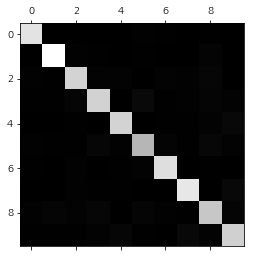

In [91]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보입니다.
- 숫자 5는 다른 숫자보다 조금 더 어두워 보입니다. <br>
   이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻입니다.
- 그래프의 에러 부분에 초점을 맞춰보겠습니다.<br>
   `오차 형렬의 각 값을 대응하는 클래스의 이미지 재수로 나누어, 에러의 절대 수가 아닌 에러 비율을 비교합니다.`

In [94]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

- 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그립니다.

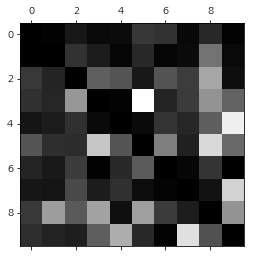

In [95]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()